In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
# seting up folder path

path = r'C:\Users\aminj\Documents\09-2024 Instacart Basket Analysis\09-2024 Instacart Basket Analysis'

# importing datasets

ords_prods_customers_final = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', '9.cust_merged.pkl'))

In [5]:
df = ords_prods_customers_final

In [7]:
# creating an empty list to store the region results
region_result = []

# creating the conditions (which state is which region)
for state in df["state"]:
    if state in ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 
                 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 
                 'New Jersey']:
        region_result.append("Northeast")
    elif state in ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 
                   'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 
                   'Minnesota', 'Iowa', 'Missouri']:
        region_result.append("Midwest")
    elif state in ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 
                   'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 
                   'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 
                   'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']:
        region_result.append("South")
    elif state in ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 
                   'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 
                   'California', 'Hawaii']:
        region_result.append("West")
    else:
        region_result.append("Unknown")

In [9]:
# adding the new region list as a column to the df
df['region'] = region_result

In [11]:
# Step 1: Distinct on user_id level
df_distinct_user = df.drop_duplicates(subset='user_id')

# Crosstab for user_id level (Region vs Spending Flag)
crosstab_user = pd.crosstab(df_distinct_user['region'], df_distinct_user['spending_flag'], dropna=False)

# Step 2: Distinct on order_id level
df_distinct_order = df.drop_duplicates(subset='order_id')

# Crosstab for order_id level (Region vs Spending Flag)
crosstab_order = pd.crosstab(df_distinct_order['region'], df_distinct_order['spending_flag'], dropna=False)

# Display the crosstabs
print("Crosstab for distinct user_id level:")
print(crosstab_user)

print("\nCrosstab for distinct order_id level:")
print(crosstab_order)

Crosstab for distinct user_id level:
spending_flag  High spender  Low spender
region                                  
Midwest                8430        27089
Northeast              6354        20310
South                 11983        38646
West                   9290        29223

Crosstab for distinct order_id level:
spending_flag  High spender  Low spender
region                                  
Midwest               38400       152493
Northeast             28846       115591
South                 53439       218814
West                  42045       167196


In [13]:
# creating the column holding maximum orders per user

df['max_order'] = df.groupby(['user_id'])['order_number'].transform(np.max)

C:\Users\aminj\AppData\Local\Temp\ipykernel_51464\3128420375.py:3: FutureWarning: The provided callable <function max at 0x000001FAC44F2340> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df['max_order'] = df.groupby(['user_id'])['order_number'].transform(np.max)


In [15]:
# creating an exclusion flag for low activity users who have less than 5 orders

df.loc[df['max_order'] < 5, 'exclusion_flag'] = 'Low-activity customer'

In [17]:
# creating an exclusion flag for low activity users who have equal and more than 5 orders

df.loc[df['max_order'] >= 5, 'exclusion_flag'] = 'Regular-activity customer'

In [19]:
# granulation on order_id level, order quantity (not distinct user_id)

df['exclusion_flag'].value_counts()

exclusion_flag
Regular-activity customer    921270
Low-activity customer         78730
Name: count, dtype: int64

In [21]:
exclusion_counts = df.groupby('exclusion_flag')['user_id'].nunique().reset_index()
exclusion_counts.columns = ['exclusion_flag', 'unique_user_count']  # Rename columns for clarity

In [23]:
# granulation on user_id level, not order quantity 

exclusion_counts

,exclusion_flag,unique_user_count
0,Low-activity customer,41711
1,Regular-activity customer,109614


In [25]:
# filtering out the low-activity users and creating the new dataset 
df_2 = df[df['exclusion_flag'] != 'Low-activity customer']

In [27]:
# checking if low-activity customers were filtered out 

df_2['exclusion_flag'].value_counts()

exclusion_flag
Regular-activity customer    921270
Name: count, dtype: int64

In [29]:
# checking if the numbers are correct 

df_2['user_id'].nunique()

109614

In [35]:
# age profile is from 18 to 81 

df_2['Age'].describe()

count    921270.000000
mean         49.484424
std          18.508229
min          18.000000
25%          33.000000
50%          49.000000
75%          65.000000
max          81.000000
Name: Age, dtype: float64

In [39]:
# Young Adults: Ages 18 to 34 (inclusive)
df_2.loc[(df_2['Age'] >= 18) & (df_2['Age'] <= 34), 'age_group'] = 'Young adults'

C:\Users\aminj\AppData\Local\Temp\ipykernel_51464\3822061598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.loc[(df_2['Age'] >= 18) & (df_2['Age'] <= 34), 'age_group'] = 'Young adults'


In [41]:
# Adults: Ages 35 to 64 (inclusive)
df_2.loc[(df_2['Age'] >= 35) & (df_2['Age'] <= 64), 'age_group'] = 'Adults'

In [45]:
# Elderly Persons: Ages 65 and above
df_2.loc[df_2['Age'] >= 65, 'age_group'] = 'Elderly adults'

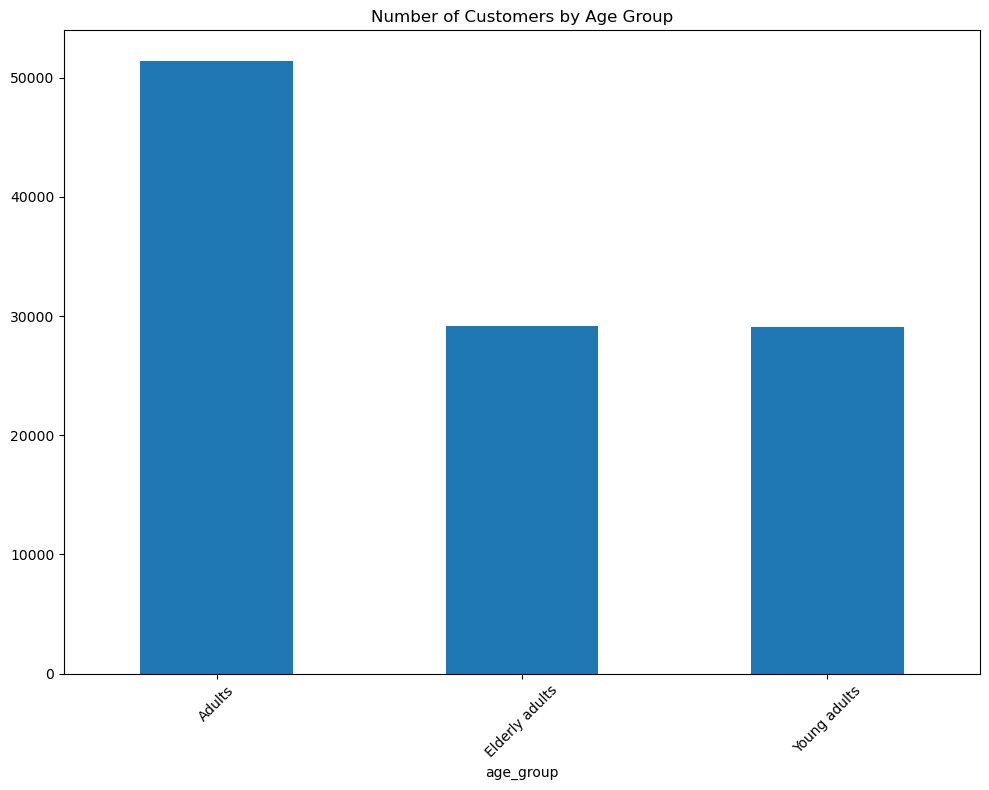

In [47]:
# Count unique user_ids for each age_group
age_group_counts = df_2.groupby('age_group')['user_id'].nunique().sort_index()

# Plot the bar graph with adjusted figure size
plt.figure(figsize=(10, 8))  # Adjust the figure size to make it taller
bar_1 = age_group_counts.plot.bar()
bar_1.set_title('Number of Customers by Age Group')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('unique_customers_by_age_group.png', bbox_inches='tight', dpi=300)
plt.show()

In [57]:
df_2.head()

,product_id,product_name,aisle_id,department_id,prices,order_id,user_id,eval_set,order_number,order_dow,...,Gender,state,Age,date_joined,n_dependants,family_status,income,region,exclusion_flag,age_group
0,1,Chocolate Sandwich Cookies,61,19,5.8,3139998,138,prior,28,6,...,Male,Minnesota,81,8/1/2019,1,married,49620,Midwest,Regular-activity customer,Elderly adults
1,1,Chocolate Sandwich Cookies,61,19,5.8,1977647,138,prior,30,6,...,Male,Minnesota,81,8/1/2019,1,married,49620,Midwest,Regular-activity customer,Elderly adults
2,1,Chocolate Sandwich Cookies,61,19,5.8,389851,709,prior,2,0,...,Female,Vermont,66,6/16/2018,2,married,158302,Northeast,Regular-activity customer,Elderly adults
5,1,Chocolate Sandwich Cookies,61,19,5.8,1701441,777,prior,16,1,...,Female,Hawaii,51,1/4/2019,2,married,57797,West,Regular-activity customer,Adults
7,1,Chocolate Sandwich Cookies,61,19,5.8,1290456,910,prior,12,3,...,Female,Tennessee,65,7/25/2019,0,divorced/widowed,44856,South,Regular-activity customer,Elderly adults


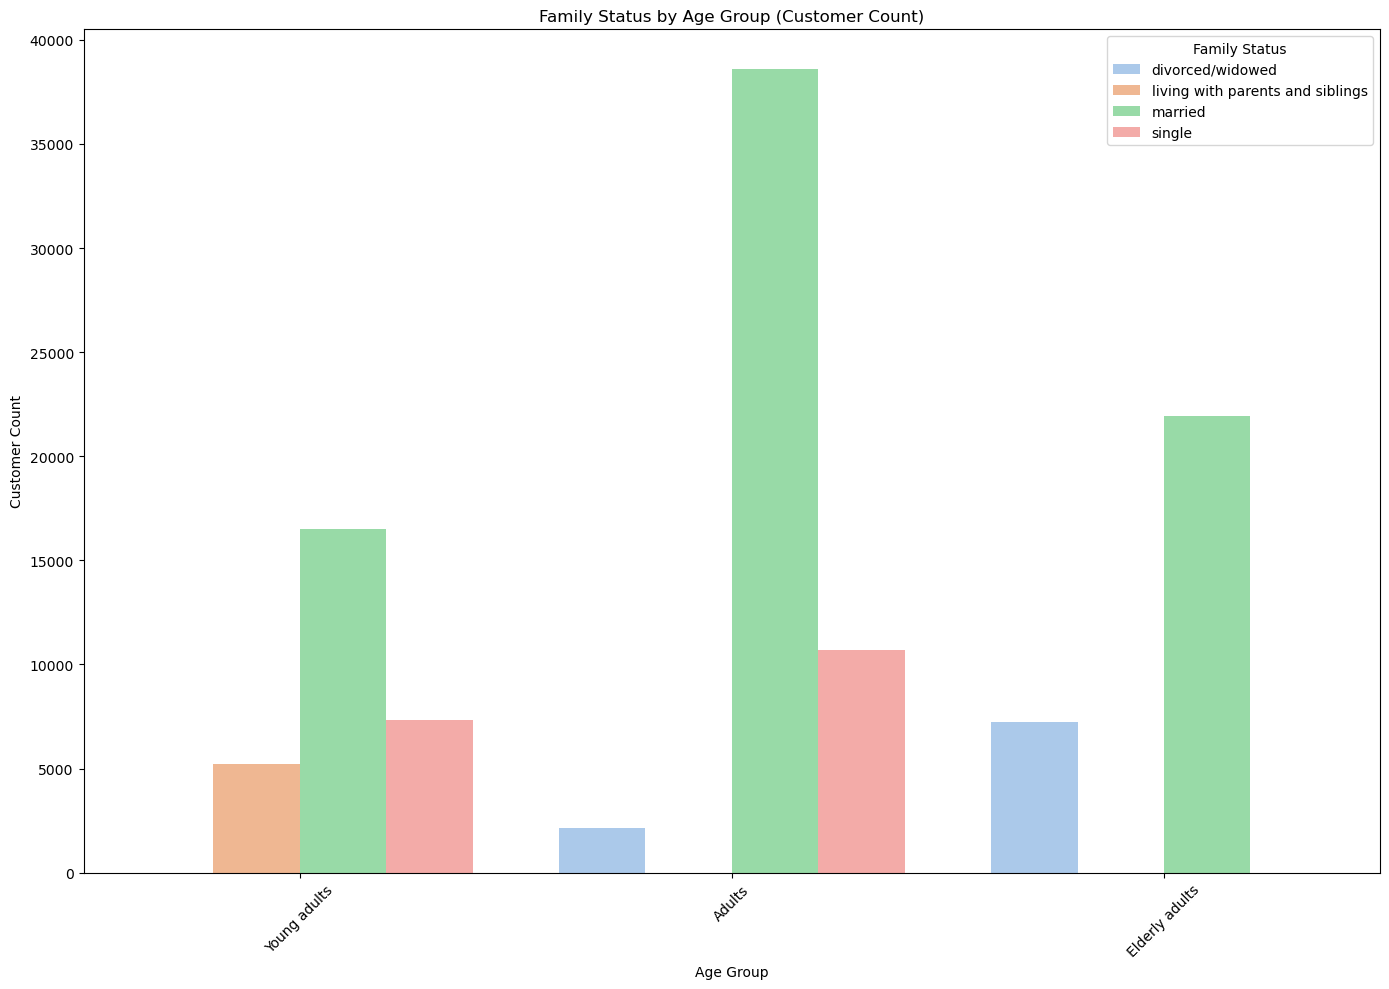

In [83]:
# Step 1: Group by age_group and fam_status, then count unique user_ids
crosstab = df_2.groupby(['age_group', 'family_status'])['user_id'].nunique().unstack(fill_value=0)

# Step 2: Reset index and melt the crosstab to long-form DataFrame
crosstab_melted = crosstab.reset_index().melt(id_vars='age_group', var_name='family_status', value_name='count')

# Define the order for age_group: young adults -> adults -> elderly adults
age_order = ['Young adults', 'Adults', 'Elderly adults']

# Set the order for the age_group column using pd.Categorical
crosstab_melted['age_group'] = pd.Categorical(crosstab_melted['age_group'], categories=age_order, ordered=True)

# Step 3: Create a grouped bar chart
plt.figure(figsize=(14, 10))
bar_2 = sns.barplot(x='age_group', y='count', hue='family_status', data=crosstab_melted, palette='pastel')

# Add title and labels
plt.title('Family Status by Age Group (Customer Count)')
plt.xlabel('Age Group')
plt.ylabel('Customer Count')
plt.legend(title='Family Status')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()
plt.show()

In [85]:
# exporting the crosstab 

bar_2.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'age_vs_fam.png'))

In [87]:
df_2['income'].describe()

count    921270.000000
mean      99989.377622
std       44934.372047
min       25911.000000
25%       66981.000000
50%       96753.000000
75%      128375.000000
max      593901.000000
Name: income, dtype: float64

In [89]:
# creating income buckets based on the 25th and 75th percentiles
# low income

df_2.loc[df_2['income'] < 67289, 'income_group'] = 'Low income'

C:\Users\aminj\AppData\Local\Temp\ipykernel_51464\1578009727.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.loc[df_2['income'] < 67289, 'income_group'] = 'Low income'


In [91]:
# medium income 
df_2.loc[(df_2['income'] >= 67289) & (df_2['income'] <= 128101), 'income_group'] = 'Medium income'

In [93]:
# high income
df_2.loc[df_2['income'] > 128101, 'income_group'] = 'High income'

C:\Users\aminj\AppData\Local\Temp\ipykernel_51464\1271499452.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['income_group'] = df_2['income_group'].astype(income_order)
C:\Users\aminj\AppData\Local\Temp\ipykernel_51464\1271499452.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_group_counts = df_2.groupby('income_group')['user_id'].nunique().sort_index()


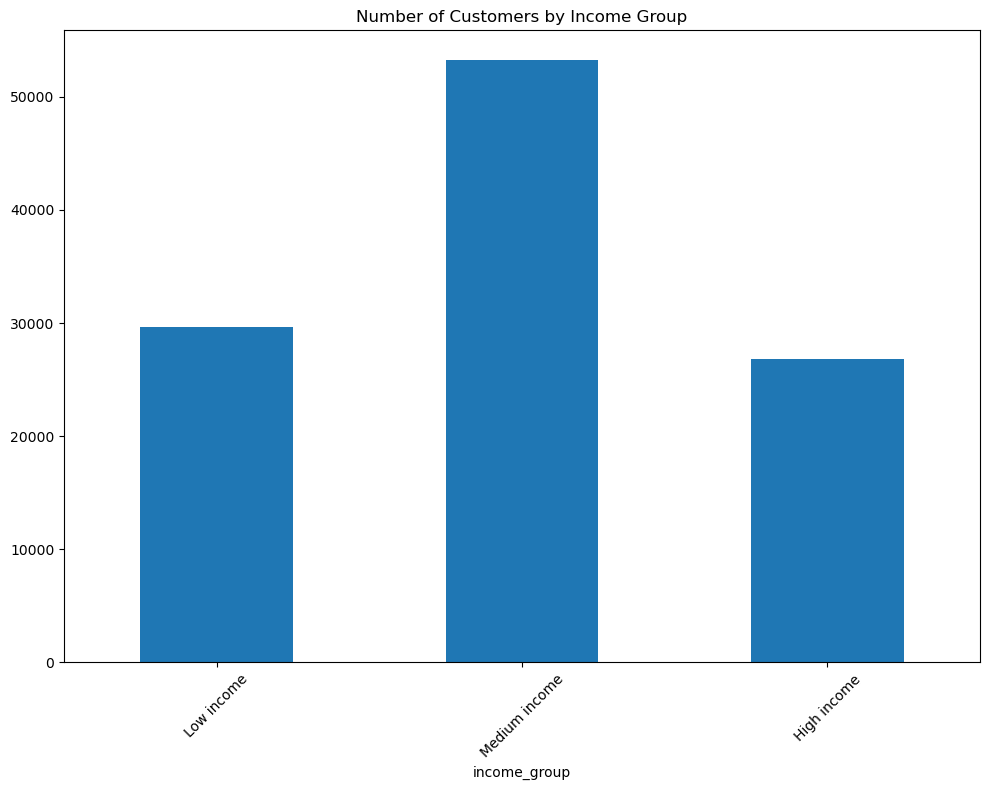

In [95]:
import pandas as pd

# Define the desired order for income groups
income_order = pd.CategoricalDtype(categories=['Low income', 'Medium income', 'High income'], ordered=True)

# Assign the ordered categories to the income_group column
df_2['income_group'] = df_2['income_group'].astype(income_order)

# Count unique user_ids for each income_group
income_group_counts = df_2.groupby('income_group')['user_id'].nunique().sort_index()

# Plot the bar graph with 45-degree x-axis label rotation
plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
bar_3 = income_group_counts.plot.bar()
bar_3.set_title('Number of Customers by Income Group')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('unique_customers_by_income_group.png', bbox_inches='tight', dpi=300)
plt.show()

In [97]:
# importing department dataset

df_dep = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'departments_wrangled.csv'), index_col = False)

In [99]:
# Step 1: Rename 'Unnamed: 0' to 'department_id'
df_dep.rename(columns={'Unnamed: 0': 'department_id'}, inplace=True)

# Step 2: Convert 'department_id' to int64
df_dep['department_id'] = pd.to_numeric(df_dep['department_id'], errors='coerce').astype('int64')

# Step 3: Verify the result
print(df_dep.dtypes)  # Check the data types of all columns
print(df_dep.head())  # Display the first few rows of the DataFrame

department_id     int64
department       object
dtype: object
   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol


In [101]:
df_dep.head(30)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [105]:
# merging datasets - left table is ords_prods_customers_final (df_2) and I am enriching this table with department info 
df_final = df_2.merge(df_dep, on = 'department_id', how = 'inner')

In [107]:
# checking if merging was successful 

df_final['_merge'].value_counts()

_merge
both          921270
left_only          0
right_only         0
Name: count, dtype: int64

In [109]:
# dropping _merge column

df_final = df_final.drop(['_merge'], axis=1)

In [111]:
df_final.head()

,product_id,product_name,aisle_id,department_id,prices,order_id,user_id,eval_set,order_number,order_dow,...,Age,date_joined,n_dependants,family_status,income,region,exclusion_flag,age_group,income_group,department
0,1,Chocolate Sandwich Cookies,61,19,5.8,3139998,138,prior,28,6,...,81,8/1/2019,1,married,49620,Midwest,Regular-activity customer,Elderly adults,Low income,snacks
1,1,Chocolate Sandwich Cookies,61,19,5.8,1977647,138,prior,30,6,...,81,8/1/2019,1,married,49620,Midwest,Regular-activity customer,Elderly adults,Low income,snacks
2,1,Chocolate Sandwich Cookies,61,19,5.8,389851,709,prior,2,0,...,66,6/16/2018,2,married,158302,Northeast,Regular-activity customer,Elderly adults,High income,snacks
3,1,Chocolate Sandwich Cookies,61,19,5.8,1701441,777,prior,16,1,...,51,1/4/2019,2,married,57797,West,Regular-activity customer,Adults,Low income,snacks
4,1,Chocolate Sandwich Cookies,61,19,5.8,1290456,910,prior,12,3,...,65,7/25/2019,0,divorced/widowed,44856,South,Regular-activity customer,Elderly adults,Low income,snacks


In [113]:
df_final['n_dependants'].value_counts()

n_dependants
0    231318
2    230785
3    230669
1    228498
Name: count, dtype: int64

Text(0.5, 1.0, 'Number of Unique Customers by Number of Dependants')

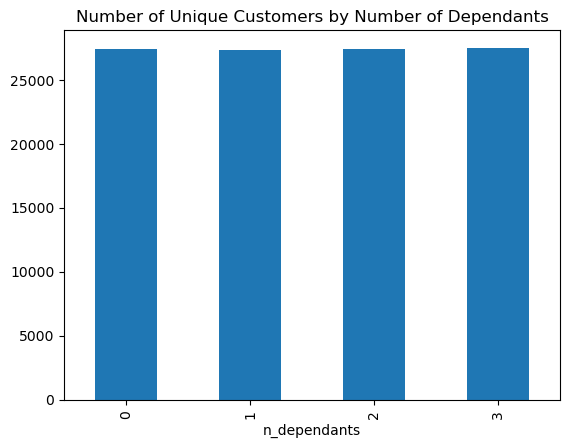

In [115]:
# Calculate the distinct count of user_id for each n_dependants value
dependant_counts = df_final.drop_duplicates(subset='user_id')['n_dependants'].value_counts().sort_index()

# Plot the bar graph
bar_4 = dependant_counts.plot.bar()
bar_4.set_title('Number of Unique Customers by Number of Dependants')

In [117]:
# Adjust layout and figure size if needed
bar_4.figure.set_size_inches(10, 6)  # Adjust the width and height as needed
plt.tight_layout()  # Automatically adjust layout

# Save the figure using the correct reference
bar_4.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'no_kids_bar.png'), bbox_inches='tight', dpi=300)

<Figure size 640x480 with 0 Axes>

In [119]:
# Creating an empty list to store the dependent results
dependants_result = []

# Creating the conditions based on the number of dependents
for n_dependants in df_final['n_dependants']:
    if n_dependants == 0:
        dependants_result.append("no kids")  # no kids
    elif n_dependants == 1:
        dependants_result.append("small family (1 kid)")  # small family
    elif n_dependants in [2, 3]:
        dependants_result.append("big family (2-3 kids)")  # big family with 2 or 3 kids

# Adding the results to the DataFrame as a new column
df_final['dependants_group'] = dependants_result

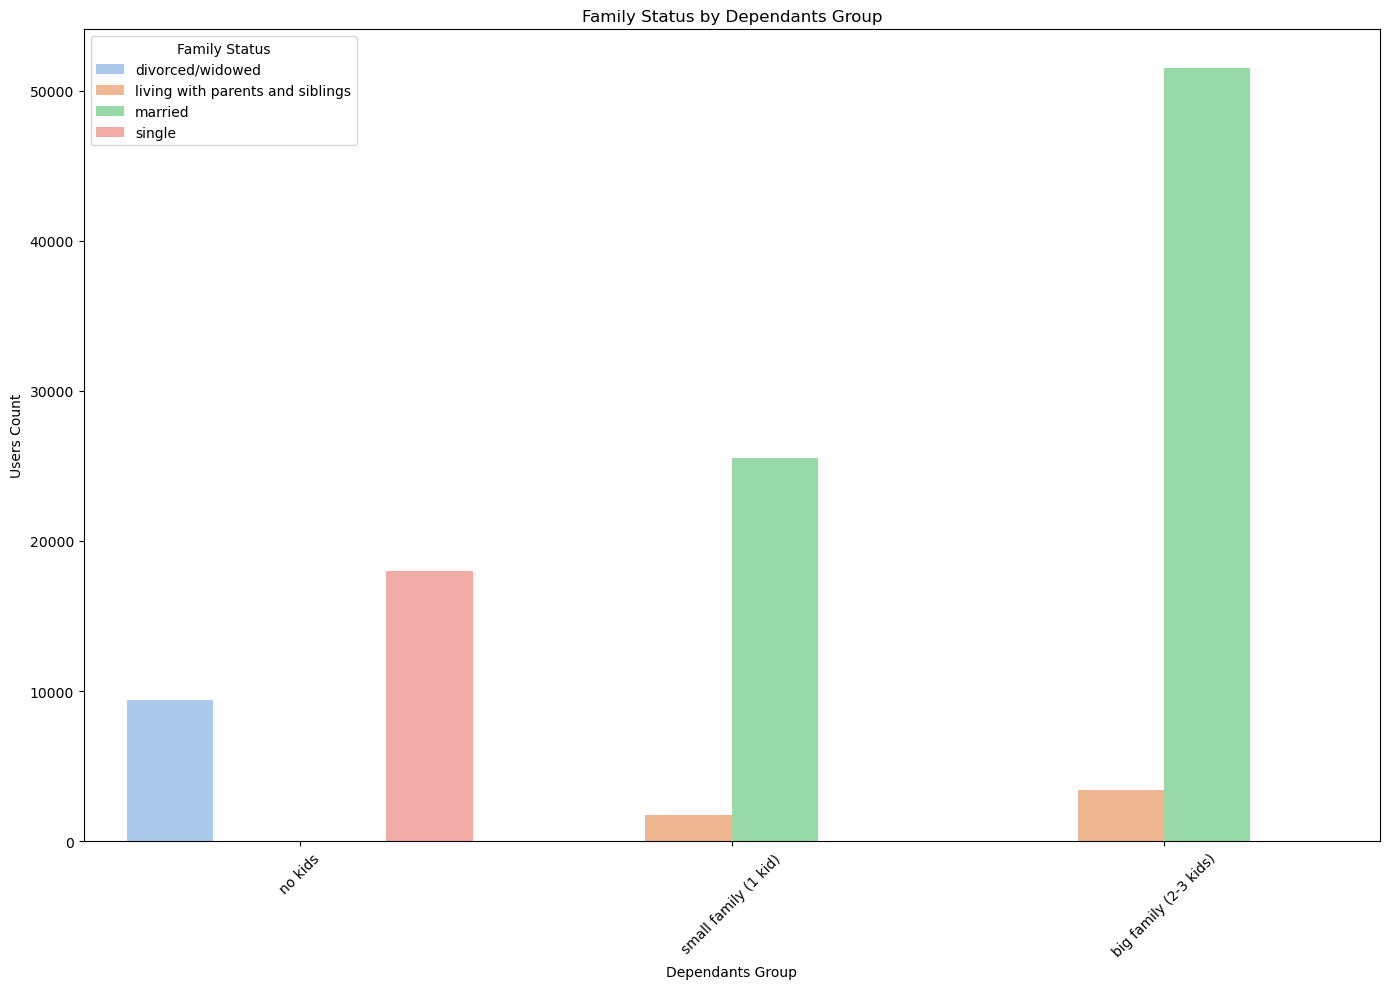

In [285]:
# Create a crosstab for dependants_group and fam_status
crosstab = df_final.groupby(['dependants_group', 'family_status'])['user_id'].nunique().unstack(fill_value=0)

# Reset index and melt the crosstab to long-form DataFrame for plotting
crosstab_melted = crosstab.reset_index().melt(id_vars='dependants_group', var_name='family_status', value_name='count')

# Define the order for dependants_group: No Kids -> Small Family -> Big Family
dependants_order = ['no kids', 'small family (1 kid)', 'big family (2-3 kids)']

# Set the order for the dependants_group column using pd.Categorical
crosstab_melted['dependants_group'] = pd.Categorical(crosstab_melted['dependants_group'], categories=dependants_order, ordered=True)

# Step 2: Create a grouped bar chart
plt.figure(figsize=(14, 10))
bar = sns.barplot(x='dependants_group', y='count', hue='family_status', data=crosstab_melted, palette='pastel')

# Add title and labels
plt.title('Family Status by Dependants Group')
plt.xlabel('Dependants Group')
plt.ylabel('Users Count')
plt.legend(title='Family Status')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

# Save the plot as a file (e.g., PNG or JPG)
plt.tight_layout()  # Ensure layout fits within the figure
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations','family_status_dependants_group.png'))  # Save with high resolution (300 dpi)

# Show the plot
plt.show()

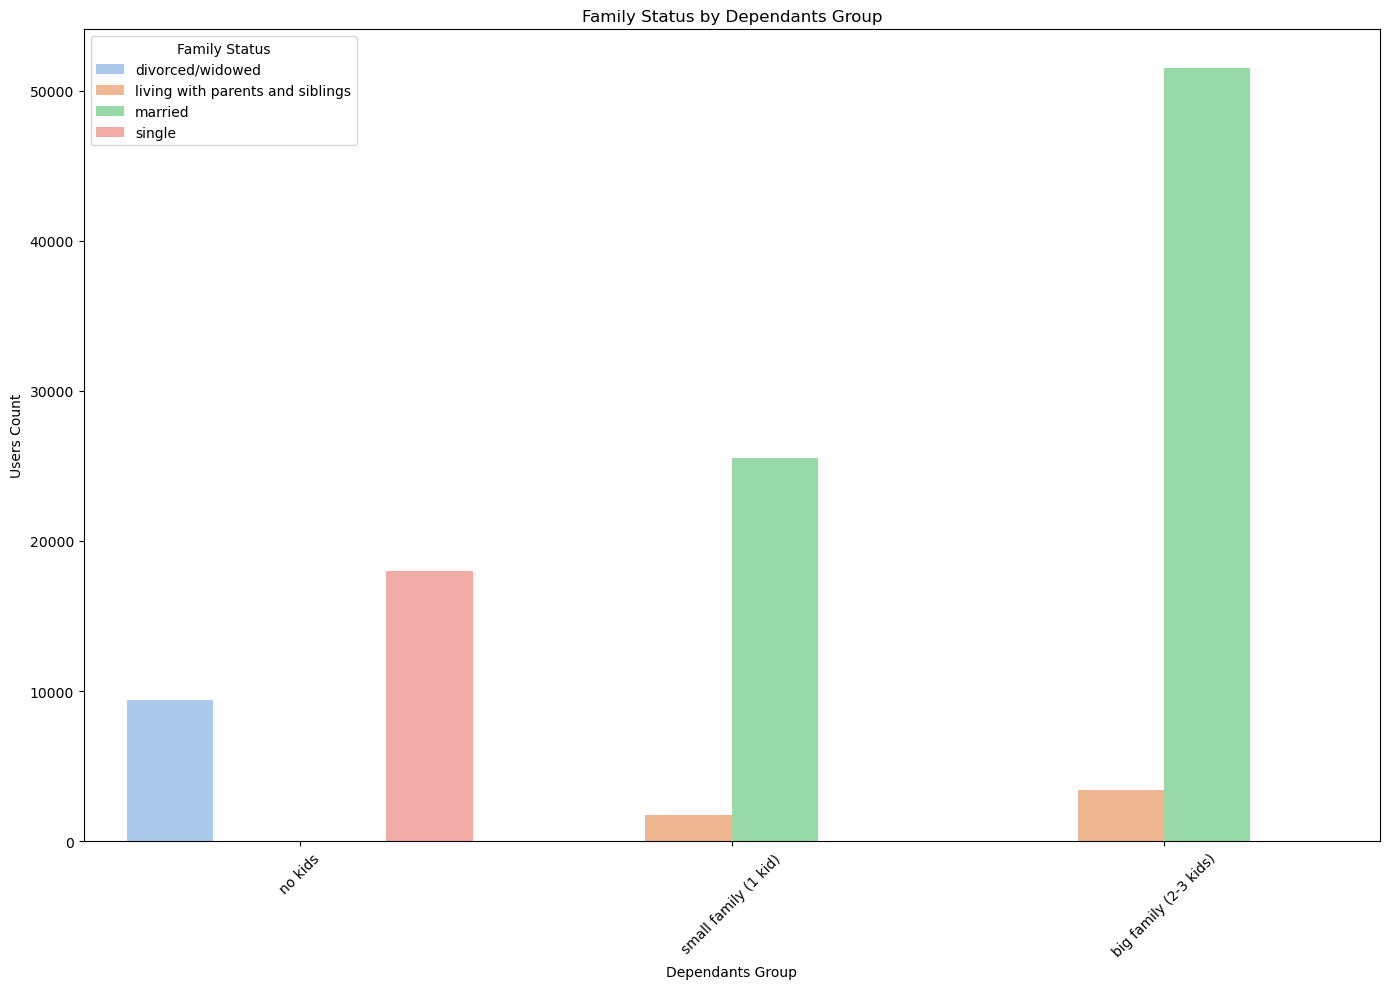

In [287]:
# Create a crosstab for dependants_group and fam_status
crosstab = df_final.groupby(['dependants_group', 'family_status'])['user_id'].nunique().unstack(fill_value=0)

# Reset index and melt the crosstab to long-form DataFrame for plotting
crosstab_melted = crosstab.reset_index().melt(id_vars='dependants_group', var_name='family_status', value_name='count')

# Define the order for dependants_group: No Kids -> Small Family -> Big Family
dependants_order = ['no kids', 'small family (1 kid)', 'big family (2-3 kids)']

# Set the order for the dependants_group column using pd.Categorical
crosstab_melted['dependants_group'] = pd.Categorical(crosstab_melted['dependants_group'], categories=dependants_order, ordered=True)

# Step 2: Create a grouped bar chart
plt.figure(figsize=(14, 10))
bar = sns.barplot(x='dependants_group', y='count', hue='family_status', data=crosstab_melted, palette='pastel')

# Add title and labels
plt.title('Family Status by Dependants Group')
plt.xlabel('Dependants Group')
plt.ylabel('Users Count')
plt.legend(title='Family Status')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

# Save the plot as a file (e.g., PNG or JPG)
plt.tight_layout()  # Ensure layout fits within the figure
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations','family_status_dependants_group1.png'))  # Save with high resolution (300 dpi)

# Show the plot
plt.show()

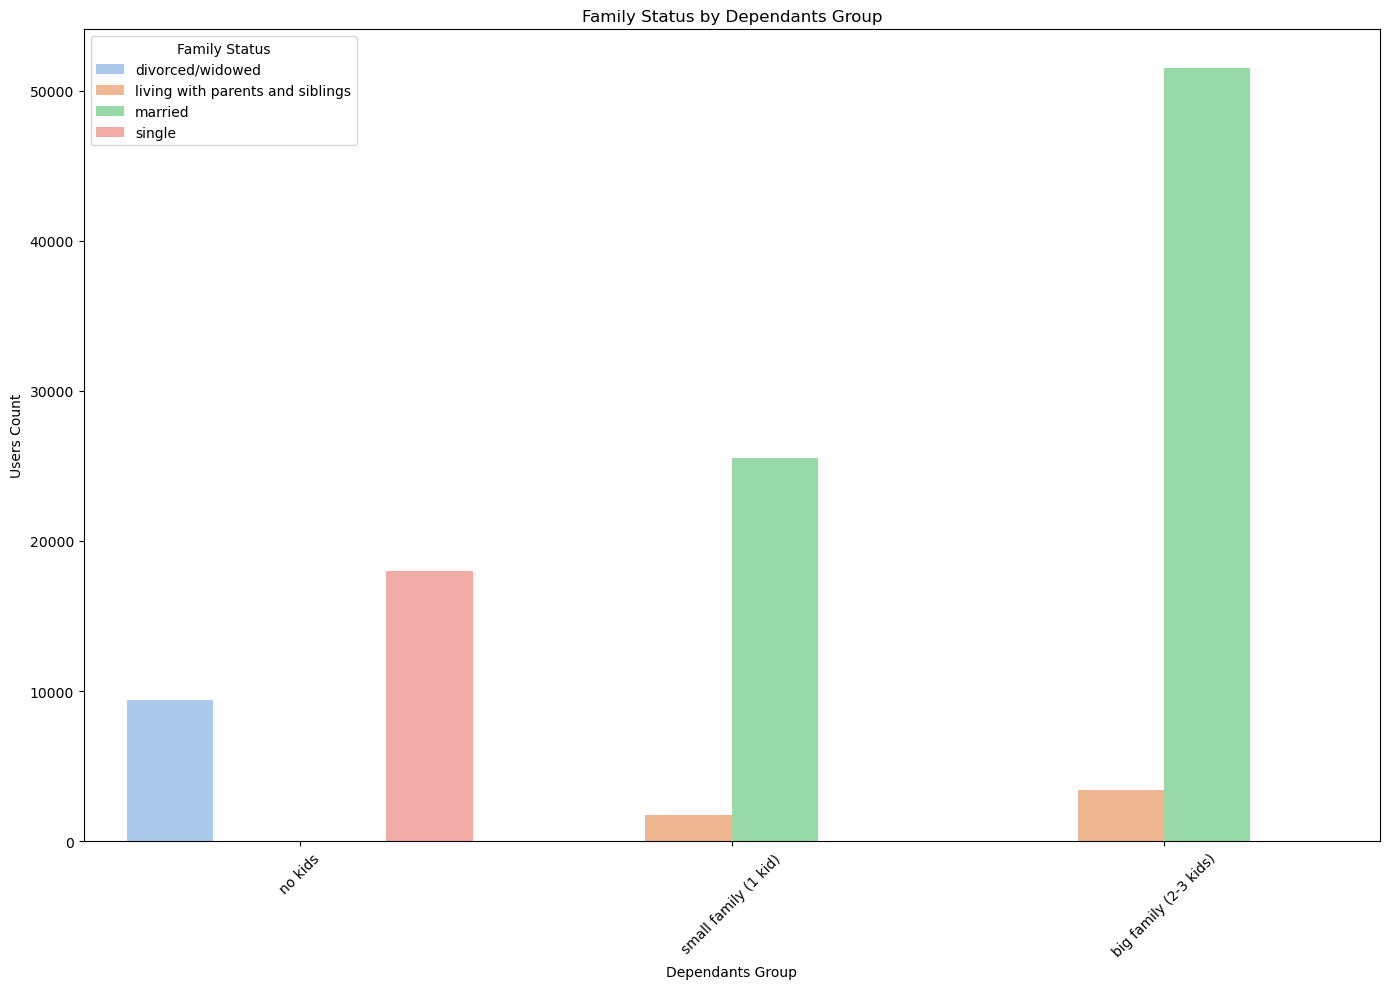

In [279]:
# Create a crosstab for dependants_group and fam_status
crosstab = df_final.groupby(['dependants_group', 'family_status'])['user_id'].nunique().unstack(fill_value=0)

# Reset index and melt the crosstab to long-form DataFrame for plotting
crosstab_melted = crosstab.reset_index().melt(id_vars='dependants_group', var_name='family_status', value_name='count')

# Define the order for dependants_group: No Kids -> Small Family -> Big Family
dependants_order = ['no kids', 'small family (1 kid)', 'big family (2-3 kids)']

# Set the order for the dependants_group column using pd.Categorical
crosstab_melted['dependants_group'] = pd.Categorical(crosstab_melted['dependants_group'], categories=dependants_order, ordered=True)

# Step 2: Create a grouped bar chart
plt.figure(figsize=(14, 10))
bar = sns.barplot(x='dependants_group', y='count', hue='family_status', data=crosstab_melted, palette='pastel')

# Add title and labels
plt.title('Family Status by Dependants Group')
plt.xlabel('Dependants Group')
plt.ylabel('Users Count')
plt.legend(title='Family Status')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

# Save the plot as a file (e.g., PNG or JPG)
plt.tight_layout()  # Ensure layout fits within the figure
plt.savefig('family_status_dependants_group.png', dpi=300)  # Save with high resolution (300 dpi)

# Show the plot
plt.show()

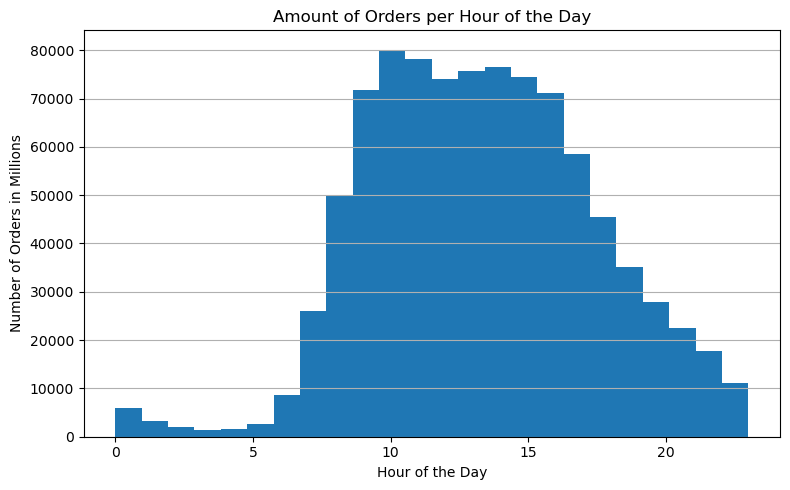

In [293]:
# Plotting the histogram for 'order_hour_of_day' with 24 bins to represent each hour
hist_hour = df_final['order_hour_of_day'].plot.hist(bins=24, figsize=(8, 5))

# Adding a title and axis labels
plt.title('Amount of Orders per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders in Millions')
plt.grid(axis='y')  # Optional: add horizontal grid lines for readability

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations','amount_of_orders_per_hour_of_day.png'))
plt.show()

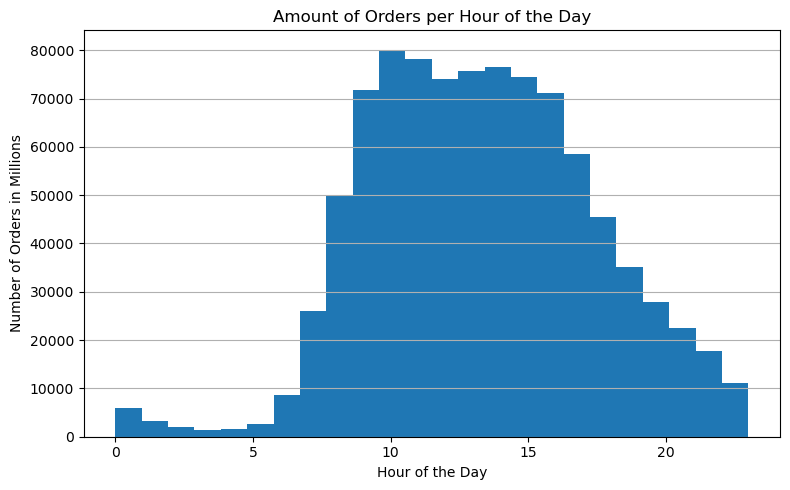

In [137]:
# Plotting the histogram for 'order_hour_of_day' with 24 bins to represent each hour
hist_hour = df_final['order_hour_of_day'].plot.hist(bins=24, figsize=(8, 5))

# Adding a title and axis labels
plt.title('Amount of Orders per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders in Millions')
plt.grid(axis='y')  # Optional: add horizontal grid lines for readability

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('amount_of_orders_per_hour_of_day.png', bbox_inches='tight', dpi=300)
plt.show()

In [143]:
# List to store the results
day_result = []

for value in df_final["order_dow"]:
    if value in [0, 1]:  # 0: Saturday, 1: Sunday (Weekend)
        day_result.append("Weekend")
    elif value in [2, 3, 4, 5, 6]:  # 2: Monday, 3: Tuesday, 4: Wednesday, 5: Thursday, 6: Friday (Weekday)
        day_result.append("Weekday")
    else:
        day_result.append("Unknown")  # For any unexpected values

# Adding the new classification to the DataFrame
df_final['day_group'] = day_result

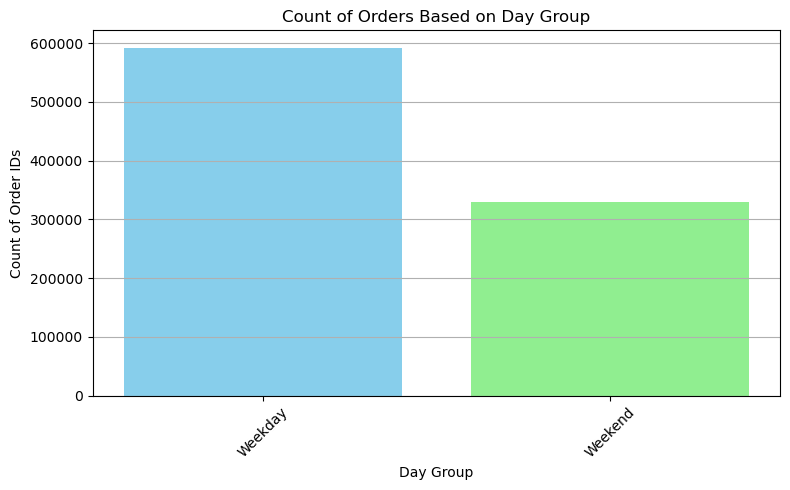

In [297]:
# Group by 'day_group' and count the number of 'order_id's
order_counts = df_final.groupby('day_group')['order_id'].count().reset_index()

# Create a bar chart
plt.figure(figsize=(8, 5))
bar_5 = plt.bar(order_counts['day_group'], order_counts['order_id'], color=['skyblue', 'lightgreen'])
plt.title('Count of Orders Based on Day Group')
plt.xlabel('Day Group')
plt.ylabel('Count of Order IDs')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations','orders_by_dayGroup.png'))
plt.show()

In [147]:
# List to store the results
hour_result = []

for hour in df_final["order_hour_of_day"]:
    if 5 <= hour <= 11:  # Morning: 5 AM - 11 AM
        hour_result.append("Morning")
    elif 12 <= hour <= 16:  # Afternoon: 12 PM - 4 PM
        hour_result.append("Afternoon")
    elif 17 <= hour <= 20:  # Evening: 5 PM - 8 PM
        hour_result.append("Evening")
    else:  # Night: 9 PM - 4 AM
        hour_result.append("Night")

# Adding the new classification to the DataFrame
df_final['hour_group'] = hour_result

C:\Users\aminj\AppData\Local\Temp\ipykernel_51464\2728453464.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order_hour_counts = df_final.groupby('hour_group')['order_id'].count().reset_index()


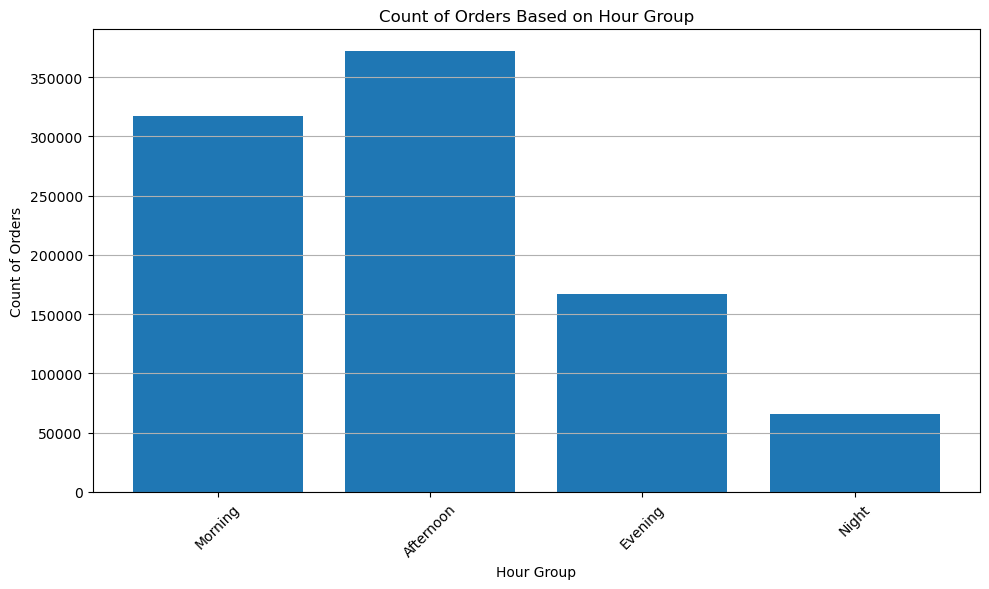

In [301]:
# Convert 'hour_group' to a categorical type with the specified order
hour_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df_final['hour_group'] = pd.Categorical(df_final['hour_group'], categories=hour_order, ordered=True)

# Group by 'hour_group' and count the number of 'order_id's
order_hour_counts = df_final.groupby('hour_group')['order_id'].count().reset_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(order_hour_counts['hour_group'], order_hour_counts['order_id'],)
plt.title('Count of Orders Based on Hour Group')
plt.xlabel('Hour Group')
plt.ylabel('Count of Orders')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations','orders_by_hourGroup.png'))
plt.show()

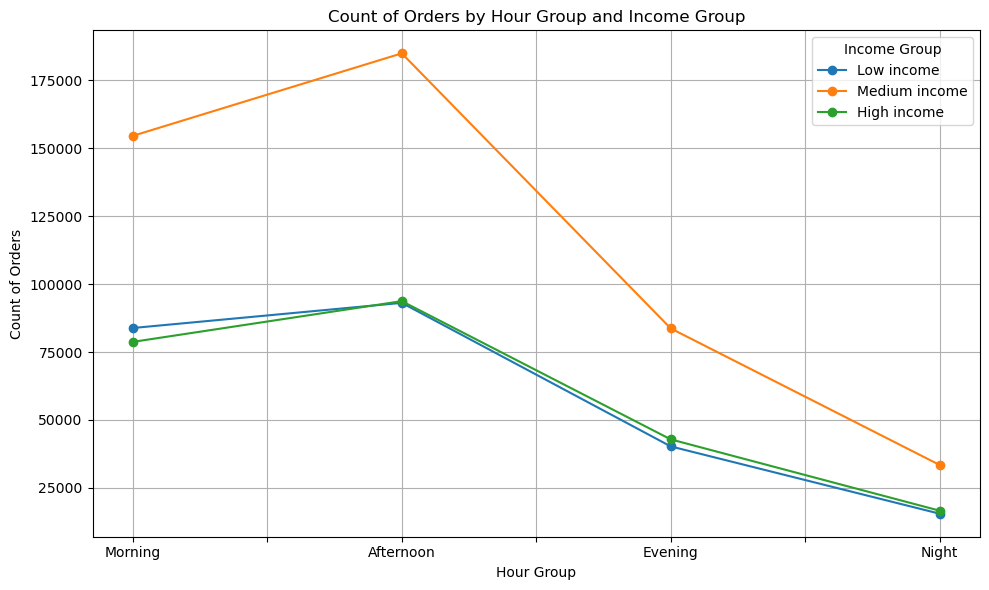

In [305]:
# Create a crosstab for hour_group and income_group
hour_income_crosstab = pd.crosstab(df_final['hour_group'], df_final['income_group'])

# Sort the index to ensure the x-axis flows in the logical order of the day
hour_income_crosstab = hour_income_crosstab.reindex(['Morning', 'Afternoon', 'Evening', 'Night'])

# Plot the crosstab as a line chart
ax = hour_income_crosstab.plot(kind='line', figsize=(10, 6), marker='o')

# Customize the chart
plt.title('Count of Orders by Hour Group and Income Group')
plt.xlabel('Hour Group')
plt.ylabel('Count of Orders')
plt.xticks(rotation=0)  # Ensure x-axis labels are readable
plt.grid(axis='both')
plt.legend(title='Income Group')
plt.tight_layout()

# Adjust layout and save the figure
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations','orders_by_incomeGroyup.png'))
plt.show()

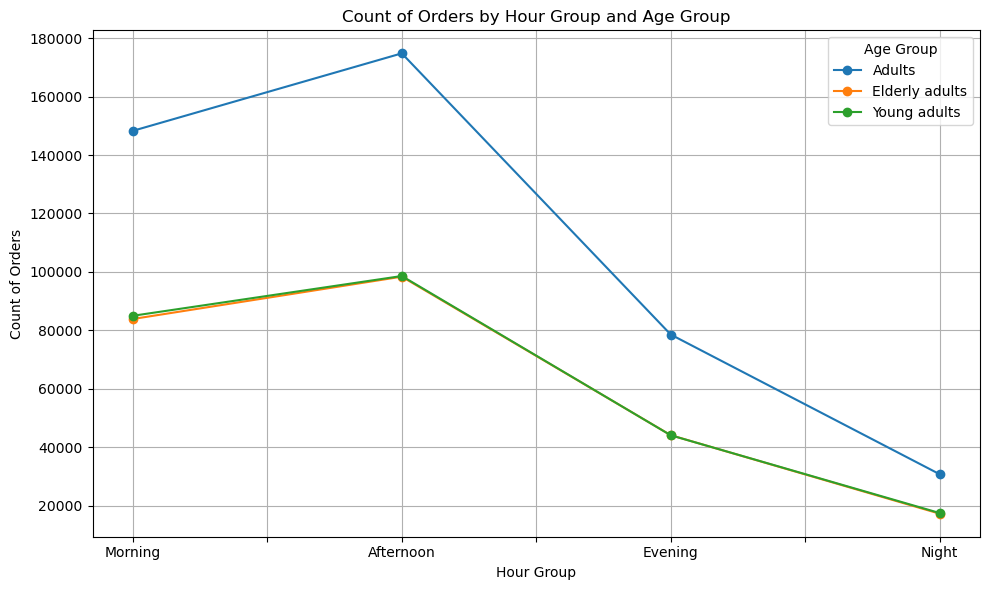

In [307]:
# Create a crosstab with hour_group on the index and age_group as columns
hour_age_crosstab = pd.crosstab(df_final['hour_group'], df_final['age_group'])

# Reorder the hour groups for a logical flow in the day
hour_age_crosstab = hour_age_crosstab.reindex(['Morning', 'Afternoon', 'Evening', 'Night'])

# Plot the crosstab as a line chart
ax = hour_age_crosstab.plot(kind='line', figsize=(10, 6), marker='o')

# Customize the chart
plt.title('Count of Orders by Hour Group and Age Group')
plt.xlabel('Hour Group')
plt.ylabel('Count of Orders')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal for readability
plt.grid(axis='both')
plt.legend(title='Age Group')  # Set legend title to Age Group
plt.tight_layout()

# Adjust layout and save the figure
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations','orders_by_income&Age.png'))
plt.show()

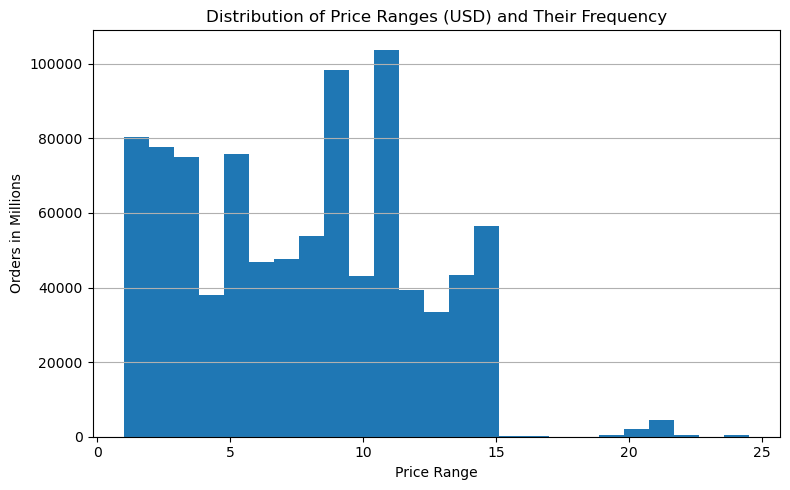

In [309]:
# Plotting the histogram for the 'prices' column
hist_o = df_final['prices'].plot.hist(bins=25, figsize=(8, 5))

# Adding a title and labels
plt.title('Distribution of Price Ranges (USD) and Their Frequency')
plt.xlabel('Price Range')
plt.ylabel('Orders in Millions')
plt.grid(axis='y')  # Optional: add grid lines for better readability

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations','Prices.png'))


# Show the plot
plt.show()

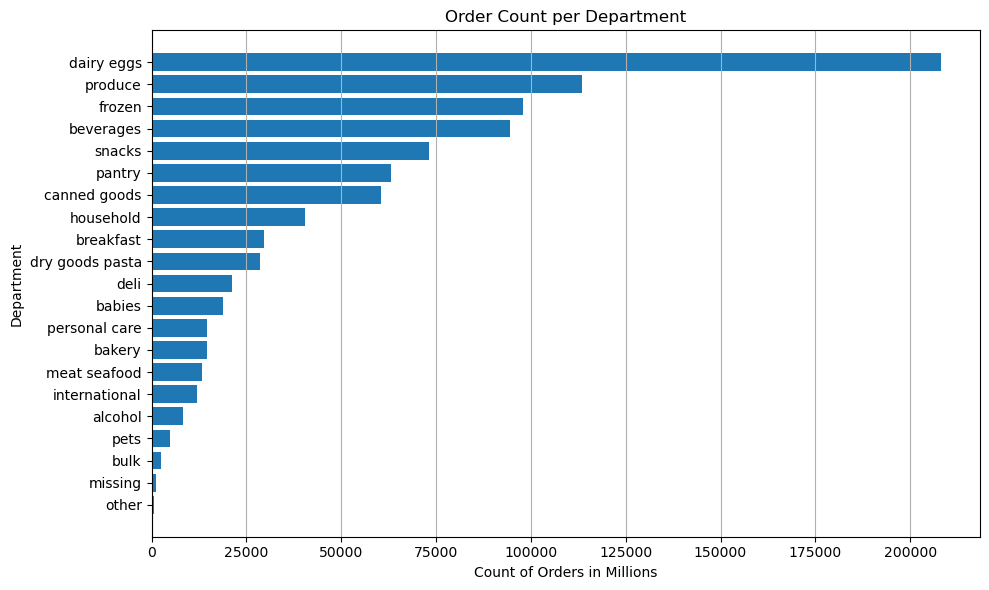

In [311]:
# Group by 'department' and count the number of 'order_id's
dept_order_counts = df_final.groupby('department')['order_id'].count().reset_index()

# Sort the counts in descending order
dept_order_counts = dept_order_counts.sort_values(by='order_id', ascending=True)

# Plot the counts as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(dept_order_counts['department'], dept_order_counts['order_id'], )

# Add a title and labels
plt.title('Order Count per Department')
plt.ylabel('Department')  # y-axis label since the bars are horizontal
plt.xlabel('Count of Orders in Millions')
plt.grid(axis='x')  # Add grid lines on the x-axis for better readability

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations','orders_by_department.png'))

# Show the plot
plt.show()

In [193]:
# Select columns that contain '_flag' in their names
flag_columns = df_final.filter(like='_flag').columns

# Print unique values for each of the '_flag' columns
for col in flag_columns:
    unique_values = df_final[col].unique()
    print(f"Column: {col}\nUnique Categories: {unique_values}\n")

Column: loyalty_flag
Unique Categories: ['Regular customer' 'New customer' 'Loyal customer']

Column: spending_flag
Unique Categories: ['High spender' 'Low spender']

Column: exclusion_flag
Unique Categories: ['Regular-activity customer']



TypeError: join() got an unexpected keyword argument 'bbox_inches'

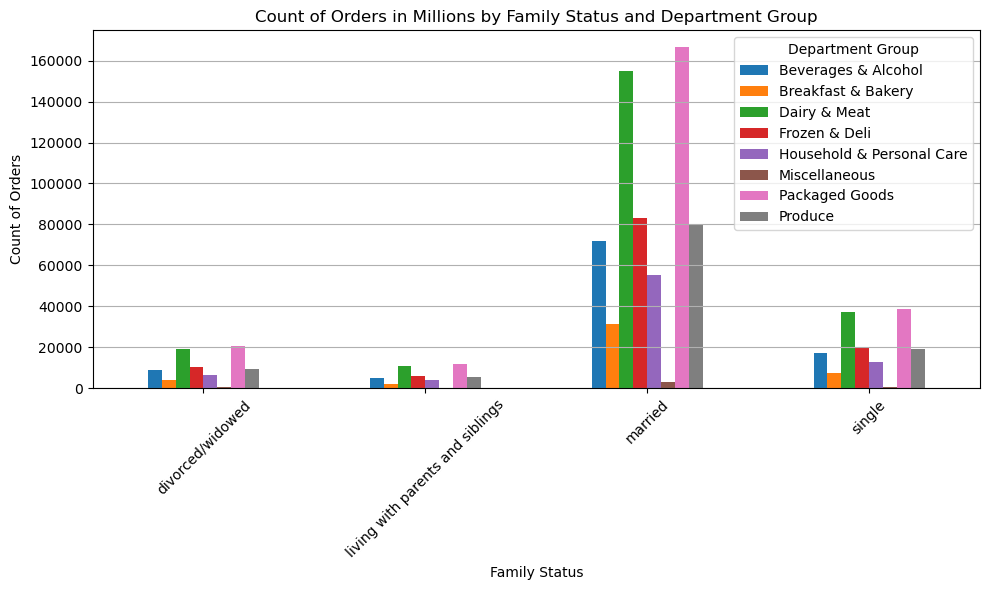

In [317]:
# Define a function to group departments into more specific categories
def group_departments(department):
    if department in ['dairy eggs', 'meat seafood']:
        return 'Dairy & Meat'
    elif department in ['breakfast', 'bakery']:
        return 'Breakfast & Bakery'
    elif department in ['frozen', 'deli']:
        return 'Frozen & Deli'
    elif department == 'produce':
        return 'Produce'
    elif department in ['beverages', 'alcohol']:
        return 'Beverages & Alcohol'
    elif department in ['canned goods', 'pantry', 'dry goods pasta', 'snacks', 'international']:
        return 'Packaged Goods'
    elif department in ['personal care', 'household', 'pets', 'babies']:
        return 'Household & Personal Care'
    else:
        return 'Miscellaneous'

# Apply the updated grouping function to the 'department' column
df_final['dept_group'] = df_final['department'].apply(group_departments)

# Crosstabs for the updated grouped departments vs family status, income group, region, and age group
# Based on 'order_id', not 'user_id'
dept_group_vs_fam_status = pd.crosstab(df_final['dept_group'], df_final['family_status'], values=df_final['order_id'], aggfunc='count')
dept_group_vs_income_group = pd.crosstab(df_final['dept_group'], df_final['income_group'], values=df_final['order_id'], aggfunc='count')
dept_group_vs_region = pd.crosstab(df_final['dept_group'], df_final['region'], values=df_final['order_id'], aggfunc='count')
dept_group_vs_age_group = pd.crosstab(df_final['dept_group'], df_final['age_group'], values=df_final['order_id'], aggfunc='count')

# Define a list of tuples containing the cross-tabulation results and plot titles
plots = [
    (dept_group_vs_fam_status, 'Family Status', 'Count of Orders in Millions by Family Status and Department Group', 'dept_group_vs_fam_status.png'),
    (dept_group_vs_income_group, 'Income Group', 'Count of Orders in Millions by Income Group and Department Group', 'dept_group_vs_income_group.png'),
    (dept_group_vs_region, 'Region', 'Count of Orders by Region in Millions and Department Group', 'dept_group_vs_region.png'),
    (dept_group_vs_age_group, 'Age Group', 'Count of Orders in Millions by Age Group and Department Group', 'dept_group_vs_age_group.png')
]
# Iterate over the list and create plots for each cross-tabulation
for crosstab, legend_title, title, filename in plots:
    plt.figure(figsize=(10, 6))
    
    # Plot the crosstab data with departments on the x-axis
    crosstab.T.plot(kind='bar', stacked=False, ax=plt.gca())
    
    plt.title(title)
    plt.xlabel(legend_title)
    plt.ylabel('Count of Orders')
    plt.xticks(rotation=45)
    plt.legend(title='Department Group')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', filename, bbox_inches='tight', dpi=300))
    plt.show()

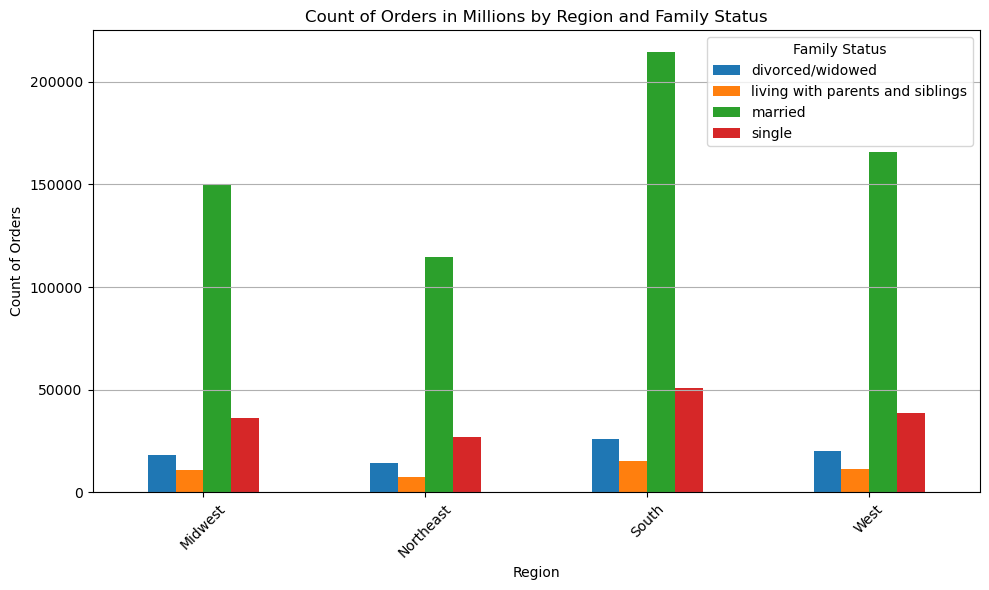

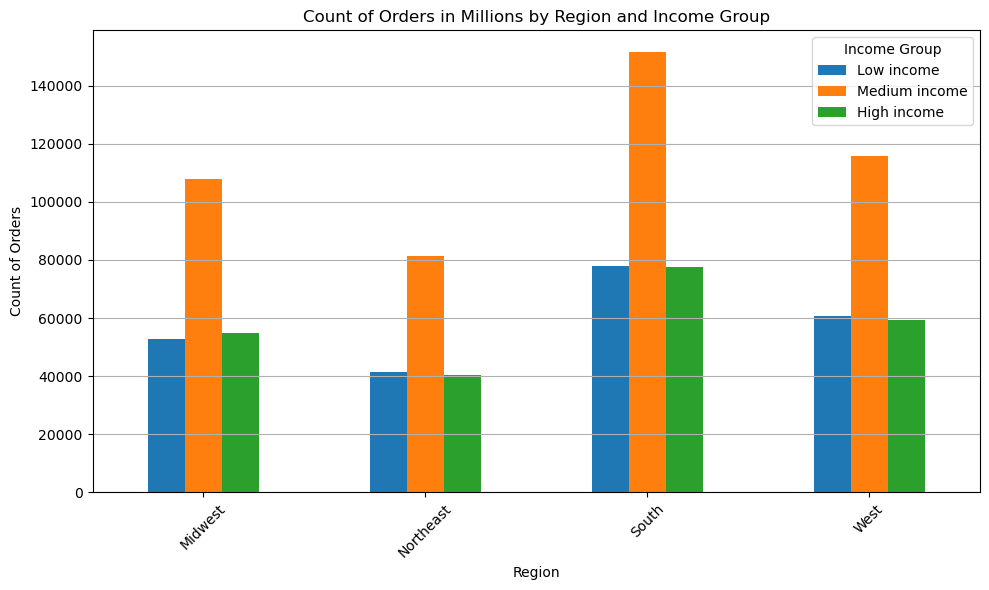

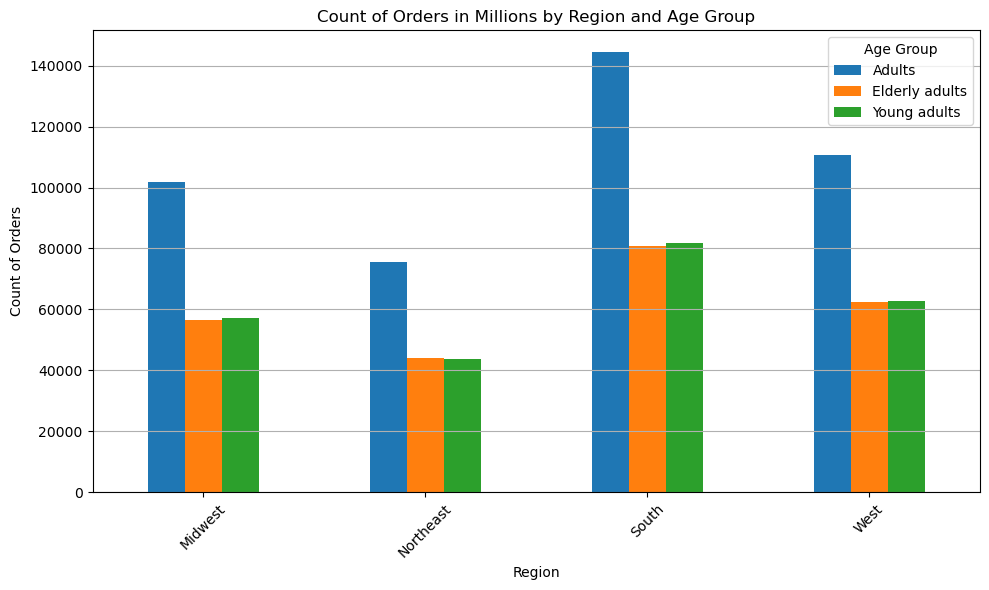

In [263]:
# Crosstabs for family status, income group, and age group vs regions
# Based on 'order_id'
region_vs_fam_status = pd.crosstab(df_final['region'], df_final['family_status'], values=df_final['order_id'], aggfunc='count')
region_vs_income_group = pd.crosstab(df_final['region'], df_final['income_group'], values=df_final['order_id'], aggfunc='count')
region_vs_age_group = pd.crosstab(df_final['region'], df_final['age_group'], values=df_final['order_id'], aggfunc='count')

# Define a list of tuples containing the cross-tabulation results and plot titles
plots = [
    (region_vs_fam_status, 'Family Status', 'Count of Orders in Millions by Region and Family Status', 'region_vs_fam_status.png'),
    (region_vs_income_group, 'Income Group', 'Count of Orders in Millions by Region and Income Group', 'region_vs_income_group.png'),
    (region_vs_age_group, 'Age Group', 'Count of Orders in Millions by Region and Age Group', 'region_vs_age_group.png')
]

# Iterate over the list and create plots for each cross-tabulation
for crosstab, legend_title, title, filename in plots:
    plt.figure(figsize=(10, 6))
    
    # Plot the crosstab data with regions on the x-axis
    crosstab.plot(kind='bar', stacked=False, ax=plt.gca())
    
    plt.title(title)
    plt.xlabel('Region')  # Set the x-axis label to 'Region'
    plt.ylabel('Count of Orders')
    plt.xticks(rotation=45)
    plt.legend(title=legend_title)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()

In [265]:
# exporting data to pkl

df_final.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'df_final_achievement.pkl'))